In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
import time

matplotlib.use('nbagg')
%matplotlib inline

In [2]:
def load_image(path, threshold = int(255/2)):
    '''
    Loads an image using OpenCV, and converts it to a binary image.
    '''
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # convert to binary image (obstacle = 255, non-obstacle = 0)
    img = img > threshold
    #_, img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return img

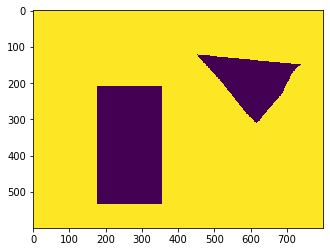

In [3]:
img = load_image("test_1.jpg")
plt.imshow(img)

In [4]:
class Component:
    
    def __init__(self):
        self.id = None
        
        # left and right bounds of the component
        self.x_min = None
        self.x_max = None
        
        # center of the component
        self.center = [None, None]
        
        # the y coordinates of the left bound of the component
        # the x coordinates of all these points are x_min
        self.left = []
        # similar as left
        self.right = []
        
        # the x-y coordinates of the upper bound of the component
        # ceiling[x] = y
        self.ceiling = {}
        # similar as ceiling
        self.floor = {}
        
    def contains(self, point):
        x, y = point
        if x < self.x_min or x > self.x_max:
            return False
        y_min = self.floor[x]
        y_max = self.ceiling[x]
        if y < y_min or y > y_max:
            return False
        return True
        
    def __repr__(self):
        return "{}".format(self.center)
    
    def plot(self, plt, s = 1.0):
        xs = []
        ys = []
        
        # points on the boundary
        for y in self.left:
            xs.append(self.x_min)
            ys.append(y)
        for y in self.right:
            xs.append(self.x_max)
            ys.append(y)
        for x in self.ceiling:
            xs.append(x)
            ys.append(self.ceiling[x])
        for x in self.floor:
            xs.append(x)
            ys.append(self.floor[x])
           
        # center point
        xs.append(self.center[0])
        ys.append(self.center[1])
        
        plt.scatter(xs, ys, s = s)
        

def get_column_components(column):
    """
    Given a column of the image, calculates the connected components of the column.
    For example, if there is an obstacle at column[200:300], and the column range is 0 -> 600,
    this function will return [(0, 200), (300, 600)]
    """
    component_start_idx = 0
    rv = []
    inside_obstacle = False
    for i in range(1, len(column)):
        
        # We have just hit an obstacle. The connected component ends here
        if not inside_obstacle and not column[i] and column[i-1]:
            component = (component_start_idx, i)
            rv.append(component)
            inside_obstacle = True
        
        # We are not inside an obstacle anymore! Reset flag and the component_start_idx
        if inside_obstacle and column[i]:
            inside_obstacle = False
            component_start_idx = i
    rv.append((component_start_idx, len(column)))
    return rv


def calculate_components(partitioned_image, num_components):
    """
    Given the partitioned image and the number of components, this will calculate a list of 
    the Component class (at the top).
    """
    rv = []
    H, W = partitioned_image.shape
    # ignore component 0 since that is the obstacles
    for i in range(1, num_components+1):
        component = Component()
        component.x_min = W-1
        component.x_max = 0
        component.id = i
        for y in range(H):
            for x in range(W):
                if partitioned_image[y, x] != i:
                    continue
                if x < component.x_min:
                    component.x_min = x
                    component.left = [y]
                elif x == component.x_min:
                    component.left.append(y)

                if x > component.x_max:
                    component.x_max = x
                    component.right = [y]
                elif x == component.x_max:
                    component.right.append(y)

                if x not in component.ceiling or y > component.ceiling[x]:
                    component.ceiling[x] = y

                if x not in component.floor or y < component.floor[x]:
                    component.floor[x] = y
        
        center_x = int((component.x_max + component.x_min)/2)
        center_y = (component.ceiling[center_x] + component.floor[center_x])/2
        component.center = (center_x, int(center_y))
        rv.append(component)
    
    return rv


def calculate_connectivity_table(prev_cc, curr_cc):
    """
    Calculates the following table:
    rv[i, j] = True if prev_cc[i] and curr_cc[j] are connected
    otherwise rv[i, j] = False
    """
    rv = np.zeros((len(prev_cc), len(curr_cc)))
    for i in range(len(prev_cc)):
        prev = prev_cc[i]
        for j in range(len(curr_cc)):
            curr = curr_cc[j]
            
            if min(prev[1], curr[1]) > max(prev[0], curr[0]):
                rv[i, j] = True
            else:
                rv[i, j] = False
    return rv

def partition_image(image):
    H, W = image.shape
    partitioned_image = np.zeros(image.shape, dtype=int)
    
    prev_cc = None
    prev_component_values = None
    num_components = 0
    
    # Sweep left to right
    for i in range(W):
        curr_col = image[:, i]
        
        # get the connected components of the column
        curr_cc = get_column_components(curr_col)
        
        # first iteration, start a new component
        if i == 0:
            num_components += 1
            curr_component_values = [num_components for _ in range(len(curr_cc))]
        else:
            curr_component_values = [0 for _ in range(len(curr_cc))]
            connected = calculate_connectivity_table(prev_cc, curr_cc)
            
            for j in range(len(prev_cc)):
                # If the prev_cc[j] is connected to exactly one of the components in curr_cc,
                # just copy the previous component values over for that connected component
                if np.sum(connected[j, :]) == 1:
                    for k in range(len(curr_cc)):
                        if connected[j, k]:
                            curr_component_values[k] = prev_component_values[j]
                # prev_cc[j] is connected to multiple components in curr_cc.
                # That means this is an IN event (we have hit a polygon),
                # so we will start a new component for each of the current column components
                elif np.sum(connected[j, :]) > 1:
                    for k in range(len(curr_cc)):
                        if connected[j, k]:
                            num_components += 1
                            curr_component_values[k] = num_components
                            
            for j in range(len(curr_cc)):
                # curr_cc[j] is connected to multiple components in prev_cc.
                # That means that this is an OUT event (we have just left a polygon),
                # so we will start a new component merging previous ones
                if np.sum(connected[:, j]) > 1:
                    num_components += 1
                    curr_component_values[j] = num_components
        
        
        # set the values for each component for the current column
        for j in range(len(curr_cc)):
            component = curr_cc[j]
            component_value = curr_component_values[j]
            partitioned_image[component[0] : component[1], i] = component_value
        
        prev_cc = curr_cc
        prev_component_values = curr_component_values
    
    components = calculate_components(partitioned_image, num_components)
    
    return partitioned_image, components
        

In [5]:
class ComponentGraph:
    
    def __init__(self):
        self.adj_list = {}
        
    def add_component(self, c):
        if not c in self.adj_list:
            self.adj_list[c] = []
        
    def add_edge(self, c, d):
        assert c in self.adj_list
        assert d in self.adj_list
        
        self.adj_list[c].append(d)
        self.adj_list[d].append(c)
        
    def vertices(self):
        return self.adj_list.keys()
        
    def neighbors(self, c):
        assert c in self.adj_list
        
        return self.adj_list[c]
    
    def plot(self, plt):
        for c in self.adj_list:
            for n in self.adj_list[c]:
                xs = [c.center[0], n.center[0]]
                ys = [c.center[1], n.center[1]]
                plt.plot(xs, ys)
    
    def __repr__(self):
        rv = ""
        for c in self.adj_list:
            rv += "{}: ".format(c)
            for node in self.adj_list[c]:
                rv += "{}, ".format(node)
            rv += "\n"
        return rv
        
def reachable(component_a, component_b):
    
    # the 2 components aren't adjacent to each other, so they can't reach each other
    if abs(component_b.x_min - component_a.x_max) > 1:
        return False
    
    # TODO: do we want to have a "threshold" size to make it reachable?
    # i.e. if the components are only connected by 1 pixel should they be reachable?
    return True

def generate_graph(components):
    
    rv = ComponentGraph()
    
    for i in range(len(components)):
        a = components[i]
        rv.add_component(a)
        
        for j in range(i+1, len(components)):
            b = components[j]
            rv.add_component(b)
            if reachable(a, b):
                rv.add_edge(a, b)
                
    return rv

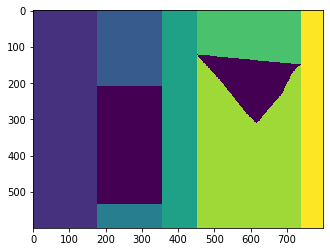

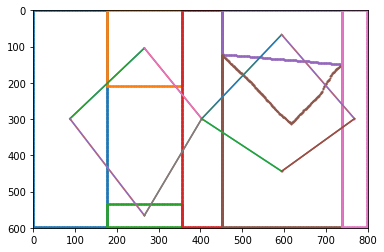

In [6]:
partitioned_img, components = partition_image(img)

# show the partitioned image (first plot)
plt.imshow(partitioned_img)

# second plot from now on
H, W = partitioned_img.shape
plt.figure()
plt.ylim((H, 0))
plt.xlim((0, W))

# plot the boundaries + center of each component
for c in components:
    c.plot(plt)
    
graph = generate_graph(components)

# plot the lines connecting the components
graph.plot(plt)

plt.show()

In [13]:
def plan_component(c, width):
    start_x = c.x_min
    end_x = c.x_max
    
    rv = []
    going_down = True
    
    for x in range(start_x + width//2, end_x + width, width):
        x = min(x, end_x - width//2)
        if going_down:
            start_y = c.floor[x] + width//2
            end_y = c.ceiling[x] - width//2
            step = 1 * width
        else:
            start_y = c.ceiling[x] - width//2
            end_y = c.floor[x] + width//2
            step = -1 * width
        for y in range(start_y, end_y + step, step):
            if step > 0:
                y = min(end_y, y)
            else:
                y = max(end_y, y)
            rv.append((x, y))
        going_down = not going_down
    return rv


def plot_path(path, component, width):
    from IPython import display

    xs = [e[0] for e in path]
    ys = [e[1] for e in path]
    min_x, min_y = min(xs), min(ys)
    max_x, max_y = max(xs), max(ys)
    delta = width
    
    for i in range(len(path)):
        plt.clf()
        component.plot(plt)
        plt.plot(xs, ys)
        plt.xlim(min_x - delta, max_x + delta)
        plt.ylim(max_y + delta, min_y - delta)
        plt.gca().set_aspect('equal', adjustable='box')
        x, y = path[i]
        square  = plt.Rectangle((x-width/2, y-width/2), width, width, alpha=0.5, color="red")
        plt.gcf().gca().add_artist(square)
        display.display(plt.gcf())
        display.clear_output(wait=True)


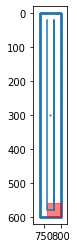

In [17]:
for c in components:
    width = 40
    rv = plan_component(c, width)
    plot_path(rv, c, width)